In [76]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [77]:
dataset = 'Seed-Sweep-ECG' # Mackey-Glass, ECG, EMG, Square-Wave, Seed-Sweep-ECG

In [78]:
# load csv files into pandas dataframes
if dataset == 'Mackey-Glass':
    results = pd.read_csv('results_MG.csv', sep=",") 
    targets = pd.read_csv('targets_MG.csv', sep=",")
elif dataset == 'ECG':
    results = pd.read_csv('results_ECG.csv', sep=",")
    targets = pd.read_csv('targets_ECG.csv', sep=",")
elif dataset == 'EMG':
    results = pd.read_csv('sweep_results_EMG.csv', sep=",")
    targets = pd.read_csv('Sweep_targets_EMG.csv', sep=",")
elif dataset == 'Square-Wave':
    results = pd.read_csv('sweep_results_SQUARE.csv', sep=",")
    targets = pd.read_csv('Sweep_targets_SQUARE.csv', sep=",")
elif dataset == 'Seed-Sweep-ECG':
    results = pd.read_csv('results_narrow_ECG.csv', sep=",")
    targets = pd.read_csv('targets_narrow_ECG.csv', sep=",")

In [79]:
# column headers for each dataframe
display(list(results.columns.values)) 
display(list(targets.columns.values)) 
res_col_names = list(results.columns.values)
targ_col_names = list(targets.columns.values)

['transient',
 'rhos',
 'reg',
 'lis',
 'iss',
 'con',
 'Nr',
 'Nl',
 '.sampling',
 'seed',
 'MSE',
 'outputs',
 'MSE_std',
 'outputs_std']

['sampling rate', 'test_targets']

In [81]:
# this function converts a column that contains long string-lists in individual cells to a list of arrays
def make_arr(col_name):
    if col_name == "test_targets":
        outputs = np.array(targets[col_name])
    else:
        #samp_sweep = results.loc[results['.sampling'] == 1]
        #outputs = np.array(samp_sweep[col_name])
        outputs = np.array(results[col_name])

    out_mat = []
    for out in outputs:
        single = out.split(',')
        arr = []

        if col_name == "test_targets":
            for i in range(len(single)):
                if i == 0:
                    arr.append(float(single[i][2:len(single[i])]))
                elif i == len(single)-1:
                    arr.append(float(single[i][0:(len(single[i])-2)]))
                else:
                    arr.append(float(single[i]))
                out_mat.append(arr)

        else:
            for i in range(len(single)):
                if i == 0:
                    arr.append(float(single[i][1:len(single[i])]))
                elif i == len(single)-1:
                    arr.append(float(single[i][0:(len(single[i])-1)]))
                else:
                    arr.append(float(single[i]))
            out_mat.append(arr)

    return out_mat

In [82]:
# this function returns the configuration of a requested index
# included MSE values
# also prints configuration with column names
def get_config(index):
    if dataset == 'Seed-Sweep-ECG':
        config = []
        for i in range(9):
            print(res_col_names[i], " = ", results[res_col_names[i]][index])
            config.append(results[res_col_names[i]][index])
        print("self_fed_MSE = ", results[res_col_names[10]][index])
        config.append(results[res_col_names[10]][index])
        print("signal_fed_MSE = ", results[res_col_names[12]][index])
        config.append(results[res_col_names[12]][index])
    else:
        config = []
        for i in range(9):
            print(res_col_names[i], " = ", results[res_col_names[i]][index])
            config.append(results[res_col_names[i]][index])
        print("self_fed_MSE = ", results[res_col_names[9]][index])
        config.append(results[res_col_names[9]][index])
        print("signal_fed_MSE = ", results[res_col_names[11]][index])
        config.append(results[res_col_names[11]][index])
    return config

In [83]:
# necessary columns to convert for results.csv
# renamed for qualitative clarity
# first index corresponds which configuration is used
self_fed_mat = make_arr("outputs")
signal_fed_mat = make_arr("outputs_std")

In [84]:
# conversion for targets
orig_signal_mat = make_arr("test_targets")

In [85]:
# resize series length if desired
def resize(mat):
    new_model = []
    for i in range(len(mat)):
        new_model.append(mat[i][:4000])
    return new_model

In [86]:
orig_signal_mat = resize(orig_signal_mat)
self_fed_mat = resize(self_fed_mat)
signal_fed_mat = resize(signal_fed_mat)

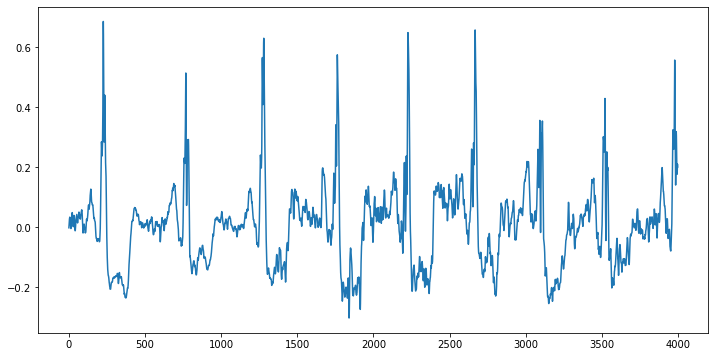

In [87]:
# Make sure the right signal has been called
plt.plot(orig_signal_mat[0])
plt.show()

In [88]:
# Calculate lowest MSE model (not always meaningful)
from sklearn.metrics import mean_squared_error
mse_list = []
for i in range(len(self_fed_mat)):
    mse = mean_squared_error(self_fed_mat[i], orig_signal_mat[0])
    mse_list.append(mse)
print(np.argmin(mse_list))

147


In [164]:
# Calculate average MSE across all seeds for each param config
avg_mse = []
by_model = []
for i in range(37):
    mse_sum = []
    row = []
    for j in range(10):
        mse_sum.append(mean_squared_error(self_fed_mat[i*10+j], orig_signal_mat[0]))
        row.append(i*10+j)
    avg_mse.append(np.mean(mse_sum))
    by_model.append(row)
    

# print(np.argmin(avg_mse))
# print(avg_mse)
# print(by_model)


1


In [90]:
# Create a model matrix, grouped by configurations across seeds
def by_model_mat(self_fed_mat, by_model, index):
    new_mat = []
    for i in by_model[index]:
        new_mat.append(self_fed_mat[i])
    return new_mat

In [63]:
# Loop across all configuration groups, running the same search constraints as seen in model_select.ipynb
viable = []
for group in range(37):

    self_fed_mat = make_arr("outputs")
    self_fed_mat = resize(self_fed_mat)
    self_fed_mat = by_model_mat(self_fed_mat, by_model, group)

    self_fed_std = []
    signal_fed_std = []
    orig_signal_std = np.std(orig_signal_mat[0])

    for i in range(len(self_fed_mat)):
        self_fed_std.append(np.std(self_fed_mat[i]))

    for i in range(len(signal_fed_mat)):
        signal_fed_std.append(np.std(signal_fed_mat[i]))

    #####

    def peak_finder(set ,index):

        if dataset == 'ECG' or dataset == 'Seed-Sweep-ECG':
            ostd = np.mean(set[index]) + np.std(set[index])*2
        elif dataset == 'EMG':
            ostd = np.mean(set[index]) + np.std(set[index])
        elif dataset == 'Square-Wave':
            ostd = np.mean(set[index]) + np.std(set[index])*.5
        elif dataset == 'Mackey-Glass':
            ostd = np.mean(set[index]) - np.std(set[index])*2

        count = 0
        for i in range(len(set[index])-1):
            if set[index][i] < ostd and set[index][i+1] > ostd:
                count += 1
        #print(count)
        return count

    #####

    orig_peaks = peak_finder(orig_signal_mat,0)
    print(f"Number of peaks in original signal: {orig_peaks}\n\n")

    std_peaks=[]
    for i in range(len(self_fed_mat)):
        std_peaks.append(peak_finder(self_fed_mat, i))

    peaked = []
    if dataset == 'Mackey-Glass':
        for i in range(len(std_peaks)):
            if std_peaks[i] > orig_peaks*(1-.15) and std_peaks[i] < orig_peaks*(1+.15):
                peaked.append(i)
    else:
        for i in range(len(std_peaks)):
            if std_peaks[i] > orig_peaks*(1-.5) and std_peaks[i] < orig_peaks*(1+.5):
                peaked.append(i)

    print(f"Number of models with peak-count in a similar range: {len(peaked)}\n")

    #####

    # Compile a list of models for a given range of standard deviations
    med_fed_std = []
    std_orig = np.std(orig_signal_mat[0])
    max_orig = np.max(orig_signal_mat[0])
    min_orig = np.min(orig_signal_mat[0])

    if dataset == "EMG":
        for i in range(len(self_fed_std)):
            if self_fed_std[i] > std_orig*(1-.5) and self_fed_std[i] < std_orig*(1+.5):
                med_fed_std.append(i)

    else:
        for i in peaked:
            if self_fed_std[i] > std_orig*(1-.5) and self_fed_std[i] < std_orig*(1+.5) and np.amax(self_fed_mat[i]) < max_orig*(1+.5) and np.amax(self_fed_mat[i]) > max_orig*(1-.5) and np.amin(self_fed_mat[i]) > min_orig*(1+.5) and np.amin(self_fed_mat[i]) < min_orig*(1-.5):
                med_fed_std.append(i)
    print(f"Model group {group}:\n\n Number of passing models = {len(med_fed_std)} \n\n Models that passed: {med_fed_std}\n\n ******************************* \n\n")
    if len(med_fed_std) > 1:
        viable.append(group)


Number of peaks in original signal: 18


Number of models with peak-count in a similar range: 1

Model group 0:

 Number of passing models = 0 

 Models that passed: []

 ******************************* 


Number of peaks in original signal: 18


Number of models with peak-count in a similar range: 0

Model group 1:

 Number of passing models = 0 

 Models that passed: []

 ******************************* 


Number of peaks in original signal: 18


Number of models with peak-count in a similar range: 1

Model group 2:

 Number of passing models = 0 

 Models that passed: []

 ******************************* 


Number of peaks in original signal: 18


Number of models with peak-count in a similar range: 1

Model group 3:

 Number of passing models = 0 

 Models that passed: []

 ******************************* 


Number of peaks in original signal: 18


Number of models with peak-count in a similar range: 2

Model group 4:

 Number of passing models = 0 

 Models that passed: []

 *****

In [98]:
# this function returns the configuration of a requested index
# included MSE values
# also prints configuration with column names
def get_config(index):
    if dataset == 'Seed-Sweep-ECG':
        config = []
        for i in range(9):
            print(res_col_names[i], " = ", results[res_col_names[i]][index])
            config.append(results[res_col_names[i]][index])
        print("self_fed_MSE = ", results[res_col_names[10]][index])
        config.append(results[res_col_names[10]][index])
        print("signal_fed_MSE = ", results[res_col_names[12]][index])
        config.append(results[res_col_names[12]][index])
    else:
        config = []
        for i in range(9):
            print(res_col_names[i], " = ", results[res_col_names[i]][index])
            config.append(results[res_col_names[i]][index])
        print("self_fed_MSE = ", results[res_col_names[9]][index])
        config.append(results[res_col_names[9]][index])
        print("signal_fed_MSE = ", results[res_col_names[11]][index])
        config.append(results[res_col_names[11]][index])
    return config

In [161]:
# Plot each model in a list of indexes
# Compare with original signal
# Print configurations
def model_comparison(top_models, feed):
    for model in top_models:
        print("Model number: ", model)
        plt.rcParams['figure.figsize'] = [12, 6]
        plt.plot(orig_signal_mat[0], label = "Original",linewidth=1.5)
        #plt.plot(signal_fed_mat[model], label = "Original")
        plt.title(f"Top {feed}-Fed Model and Original Signal for {dataset} Dataset")

        plt.rc('font', size=20) #controls default text size
        plt.rc('axes', titlesize=20) #fontsize of the title
        plt.rc('axes', labelsize=20) #fontsize of the x and y labels
        plt.rc('xtick', labelsize=20) #fontsize of the x tick labels
        plt.rc('ytick', labelsize=20) #fontsize of the y tick labels
        plt.rc('legend', fontsize=15) #fontsize of the legend

        if feed == 'Self':
            plt.plot(self_fed_mat[model], label = "Self-Fed Prediction",linewidth=2)
        elif feed == 'Signal':
            plt.plot(self_fed_mat[model], label = "Signal-Fed Prediction",linewidth=3)

        if dataset == 'Mackey-Glass' or dataset == 'Square-Wave':
            plt.xlabel("x")
            plt.ylabel("y")
        elif dataset == 'ECG' or dataset == 'EMG' or dataset == 'Seed-Sweep-ECG':
            plt.xlabel("Time Steps (700hz)")
            plt.ylabel("mV")

        plt.legend()
        plt.show()
        get_config(model)
        print("\n\n")

Model number:  200


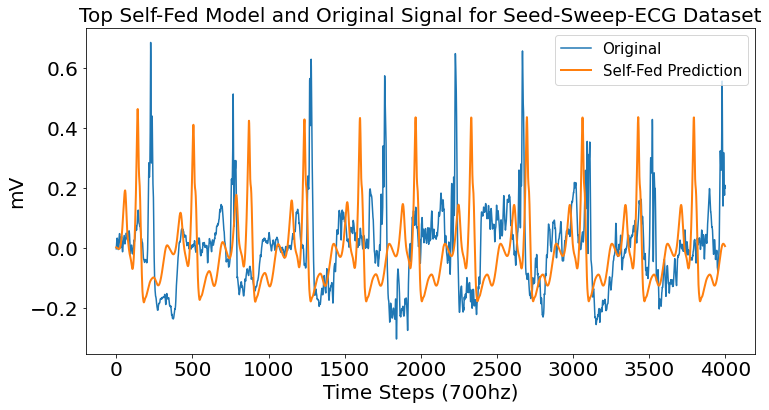

transient  =  1000
rhos  =  1.0
reg  =  10.0
lis  =  0.1
iss  =  1.0
con  =  0.2
Nr  =  200
Nl  =  5
.sampling  =  1
self_fed_MSE =  0.0326052996609518
signal_fed_MSE =  0.0012061189889264



Model number:  201


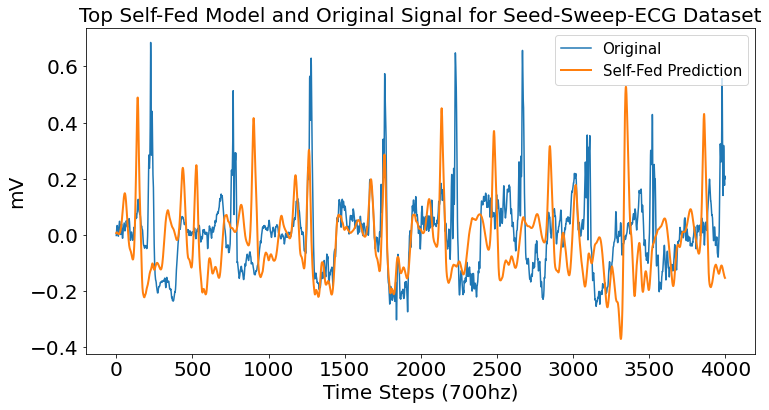

transient  =  1000
rhos  =  1.0
reg  =  10.0
lis  =  0.1
iss  =  1.0
con  =  0.2
Nr  =  200
Nl  =  5
.sampling  =  1
self_fed_MSE =  0.0292322118453076
signal_fed_MSE =  0.0011304800543286



Model number:  202


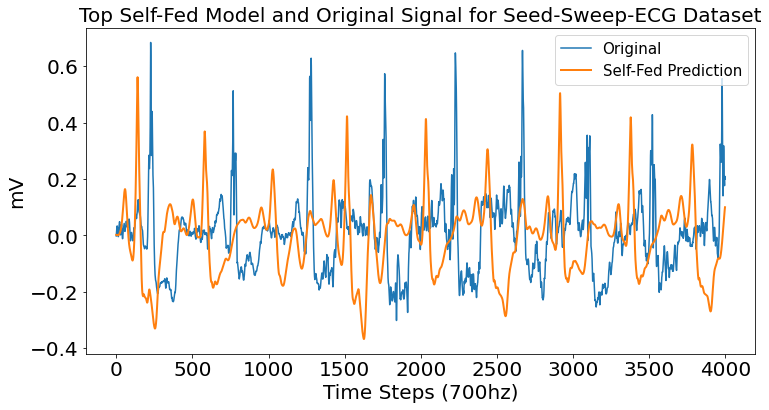

transient  =  1000
rhos  =  1.0
reg  =  10.0
lis  =  0.1
iss  =  1.0
con  =  0.2
Nr  =  200
Nl  =  5
.sampling  =  1
self_fed_MSE =  0.0401201228076862
signal_fed_MSE =  0.0012190138230455



Model number:  203


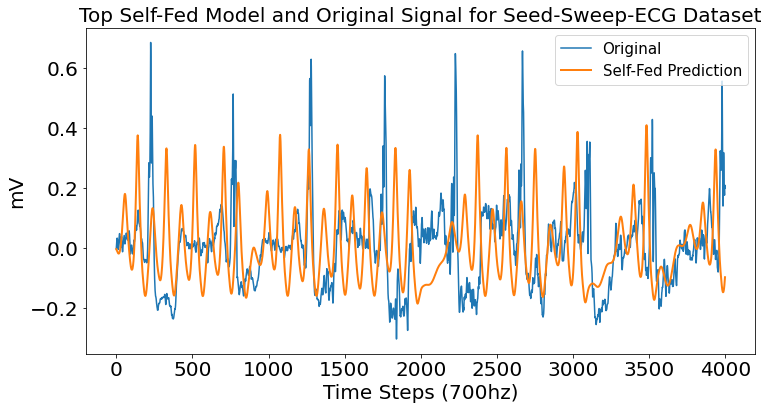

transient  =  1000
rhos  =  1.0
reg  =  10.0
lis  =  0.1
iss  =  1.0
con  =  0.2
Nr  =  200
Nl  =  5
.sampling  =  1
self_fed_MSE =  0.0311161303857314
signal_fed_MSE =  0.0011657184086468



Model number:  204


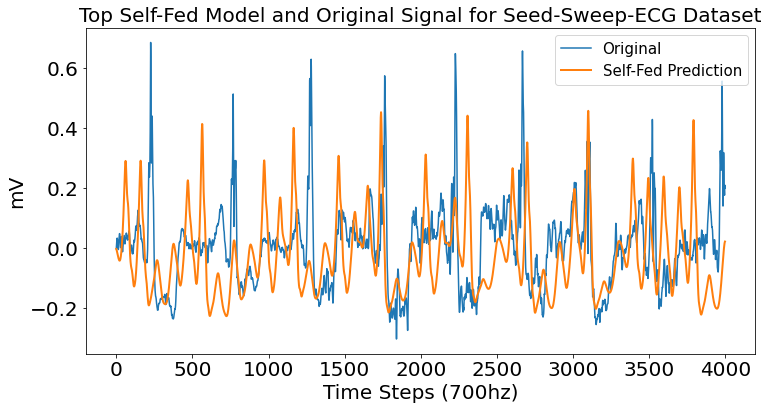

transient  =  1000
rhos  =  1.0
reg  =  10.0
lis  =  0.1
iss  =  1.0
con  =  0.2
Nr  =  200
Nl  =  5
.sampling  =  1
self_fed_MSE =  0.0295008168509933
signal_fed_MSE =  0.0010749203157779



Model number:  205


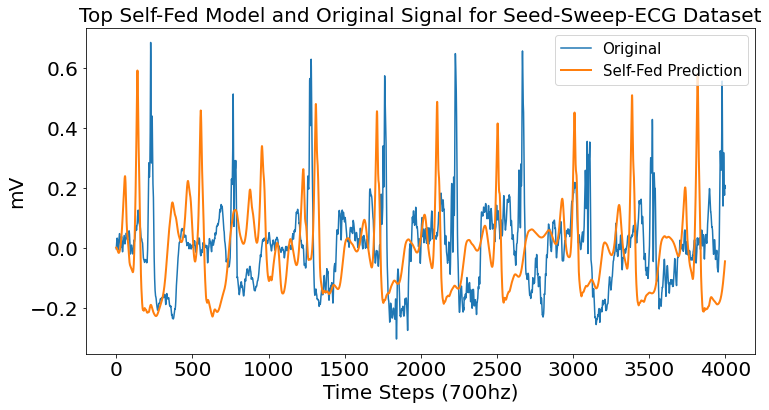

transient  =  1000
rhos  =  1.0
reg  =  10.0
lis  =  0.1
iss  =  1.0
con  =  0.2
Nr  =  200
Nl  =  5
.sampling  =  1
self_fed_MSE =  0.0398166658452891
signal_fed_MSE =  0.001163923288643



Model number:  206


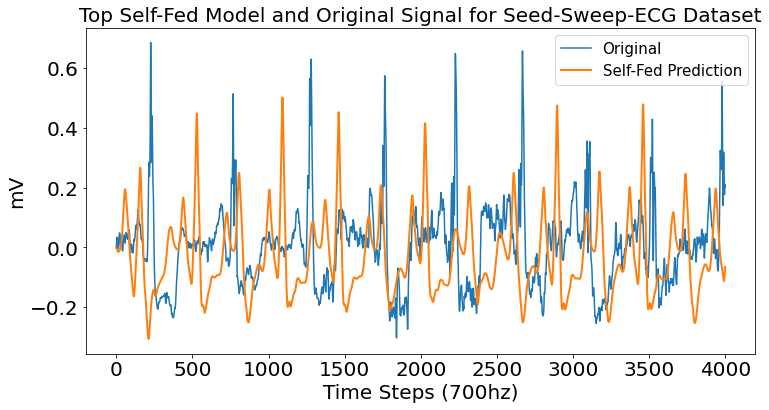

transient  =  1000
rhos  =  1.0
reg  =  10.0
lis  =  0.1
iss  =  1.0
con  =  0.2
Nr  =  200
Nl  =  5
.sampling  =  1
self_fed_MSE =  0.0371540428258472
signal_fed_MSE =  0.0010912218804406



Model number:  207


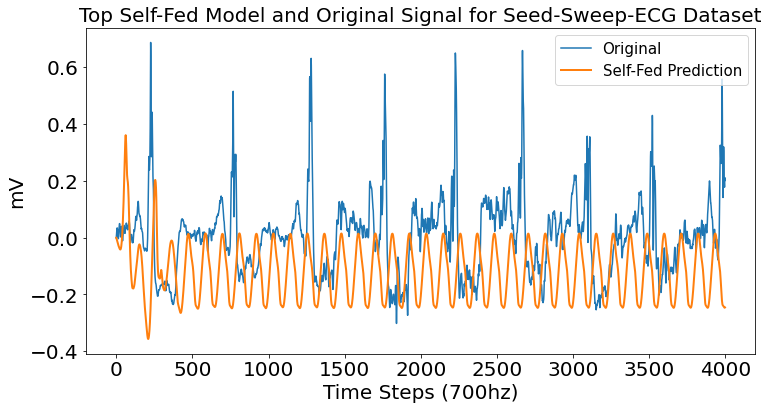

transient  =  1000
rhos  =  1.0
reg  =  10.0
lis  =  0.1
iss  =  1.0
con  =  0.2
Nr  =  200
Nl  =  5
.sampling  =  1
self_fed_MSE =  0.0478520973548932
signal_fed_MSE =  0.0011468753442087



Model number:  208


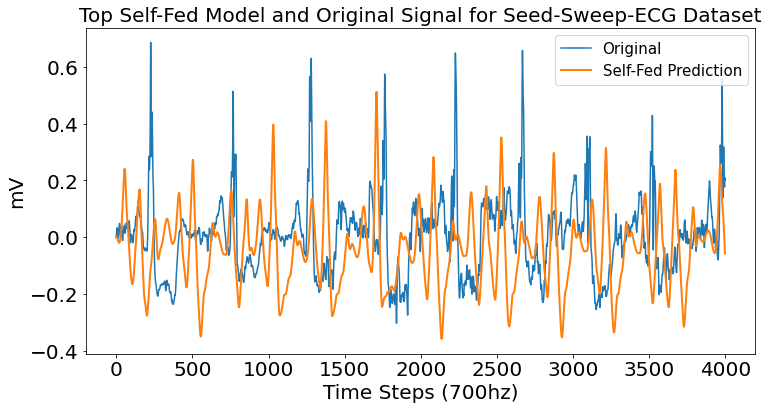

transient  =  1000
rhos  =  1.0
reg  =  10.0
lis  =  0.1
iss  =  1.0
con  =  0.2
Nr  =  200
Nl  =  5
.sampling  =  1
self_fed_MSE =  0.0380430539087317
signal_fed_MSE =  0.001151138473806



Model number:  209


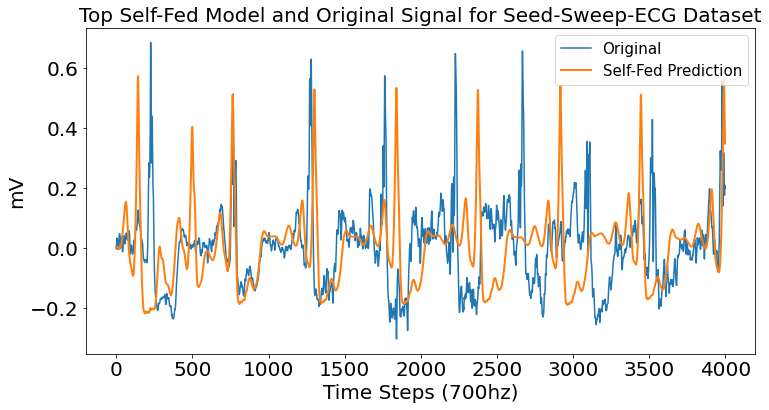

transient  =  1000
rhos  =  1.0
reg  =  10.0
lis  =  0.1
iss  =  1.0
con  =  0.2
Nr  =  200
Nl  =  5
.sampling  =  1
self_fed_MSE =  0.0306318546465937
signal_fed_MSE =  0.0012482531718045





In [167]:
# compare models of the winning configuation! 
# (20 and 21 for ECG with 20 being the heuristic winner)
top_models = by_model[20]
model_comparison(top_models, 'Self')

Group number: 18
Model number:  18


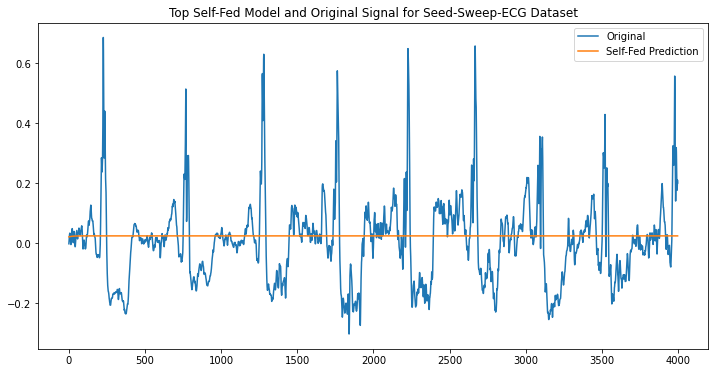

NameError: name 'res_col_names' is not defined

In [47]:
# Compare multiple groups
# Warning! High-RAM demand!
self_fed_mat = make_arr("outputs")
for i in range(len(viable)):
    print(f"Group number: {viable[i]}")
    top_models = by_model[viable[i]]
    model_comparison(top_models, 'Self')
    print("###########################################################\n###########################################################\n###########################################################\n###########################################################\n")

In [150]:
%%capture cap 
model_comparison(top_models, 'Self')

In [151]:
with open(f'top_models_{dataset}.txt', 'w') as f:
    f.write(cap.stdout)